## Building chatbot with multi tools using langgraph

### Aim is to create a chatbot with tool cappabilities from ARXIV, wikipedia search & some custom functions

In [5]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper



In [6]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=400)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

print(arxiv.invoke("What is the latest research on LangChain?"))

Published: 2025-04-03
Title: A Review of Prototyping in XR: Linking Extended Reality to Digital Fabrication
Authors: Bixun Chen, Shaun Macdonald, Moataz Attallah, Paul Chapman, Rami Ghannam
Summary: Extended Reality (XR) has expanded the horizons of entertainment and social
life and shows great potential in the manufacturing industry. Prototyping in XR
can help designers make initial proposals and


In [7]:
print(arxiv.name)

arxiv


In [8]:
print(arxiv.invoke("Attention is all you need"))

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention laye


In [9]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=400)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)

print(wikipedia.invoke("What is the latest research on LangChain?"))
#print(wikipedia.name)




Page: Wednesday (TV series)
Summary: Wednesday is an American supernatural mystery comedy television series based on the character Wednesday Addams by Charles Addams. Created by Alfred Gough and Miles Millar, it stars Jenna Ortega as the titular character, with Luis Guzmán and Catherine Zeta-Jones portraying her parents in the series. Four out of the eight episodes of the first season were directe


In [11]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct-Agent"

In [12]:
#getting my tavily search tool
from langchain_community.tools import TavilySearchResults
# from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\DELL\AppData\Local\Temp\ipykernel_3176\621676392.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [13]:
tavily.invoke("What is the latest research on LangChain?")

[{'title': "LangChain : Why It's the Foundation of AI Agent Development in the ...",
  'url': 'https://medium.com/@takafumi.endo/langchain-why-its-the-foundation-of-ai-agent-development-in-the-enterprise-era-f082717c56d3',
  'content': 'The technical maturation has been equally impressive. Recent versions of LangChain have introduced enhanced streaming capabilities and expanded partner package support. LangGraph continues to evolve with advanced features that make sophisticated multi-agent workflows not just possible, but practical. The architectural migration from Pydantic v1 to v2 and separation of community packages demonstrates the kind of engineering discipline required for enterprise adoption. [...] The business model validation is equally compelling. Reports indicate LangChain achieved significant revenue growth, with some estimates suggesting figures around $8.5 million during their first year of monetization in 2024— with innovative pricing strategies like trace retention opti

In [14]:
## I will combine all tools in a LIST

tools = [arxiv, wikipedia, tavily]

In [15]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [16]:
from langchain_core.messages import HumanMessage, AIMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the latest research on LangChain?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_30sWdULdIkAh1E9o4Ur9Mc9v', 'function': {'arguments': '{"query":"LangChain"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 219, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNNdV3vcE7lanRdOBjOYmwXSovsTt', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0854d63b-13b4-4ec8-b2aa-ee810e7a4e8d-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'LangChain'}, 'id': 'call_30sWdULdIkAh1E9o4Ur9Mc9v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 15, 'total_tokens': 234, 'input_token_details': {'audi

In [17]:
from pprint import pprint


In [18]:
llm_with_tools.invoke([HumanMessage(content=f"What is the latest research on LangChain?")]).tool_calls

[{'name': 'arxiv',
  'args': {'query': 'LangChain'},
  'id': 'call_7zyrMujub0rmAnXiDmbjY2Bd',
  'type': 'tool_call'}]

In [19]:
## state schema
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

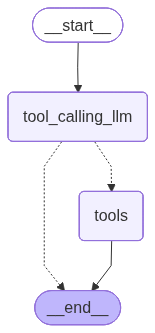

In [20]:
# Now let's create our CHATBOT using LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

## Node Definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message is a tool call, then go to the tools node
    # Otherwise, go to the END node
    tools_condition, "tools")
builder.add_edge("tools", END)

graph = builder.compile()

## Run the graph
display(Image(graph.get_graph().draw_mermaid_png()))



In [21]:
messages = graph.invoke({"messages": [HumanMessage(content=f"What is the latest research on LangChain?")]})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest research on LangChain?
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_H1zyb4j6qOSvCqizuL6TAWMi)
 Call ID: call_H1zyb4j6qOSvCqizuL6TAWMi
  Args:
    query: LangChain
================================= Tool Message =================================
Name: arxiv

Published: 2025-01-27
Title: From Prompt Injections to SQL Injection Attacks: How Protected is Your LLM-Integrated Web Application?
Authors: Rodrigo Pedro, Daniel Castro, Paulo Carreira, Nuno Santos
Summary: Large Language Models (LLMs) have found widespread applications in various
domains, including web applications, where they facilitate human interaction
via chatbots with natural language inter


In [22]:
## custom functions:
def multiply(a: int, b: int)-> int:
    """
    Multiply two numbers a and b together
    Args:
        a: int
        b: int
    Returns:
        int: The product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Add two numbers a and b together
    Args:
        a: int
        b: int
    Returns:
        int: The sum of a and b
    """
    return a + b

def divide(a: int, b: int) -> int:
    """
    Divide two numbers a and b together
    Args:
        a: int
        b: int
    Returns:
    """
    return a / b

tools = [arxiv, wikipedia, tavily, add, divide, multiply]
    

In [23]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [25]:
from pprint import pprint
from langchain_core.messages import AnyMessage

llm_with_tools.invoke([HumanMessage(content=f"what is the recent AI news?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zRG0xRV9OzVQxUM2quWRDQ4c', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 355, 'total_tokens': 375, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNNgZEm5utAg7m98SIv6Vqzobq7qr', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3062f4ef-9f5b-436f-a7b9-cff3594c4bb6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'call_zRG0xRV9OzVQxUM2quWRDQ4c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 355, 'output_tokens': 20

In [26]:
llm_with_tools.invoke([HumanMessage(content=f"what is the recent AI news?")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'call_3QoRzpBG1dPpR78sXTcUHJ2t',
  'type': 'tool_call'}]

In [29]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

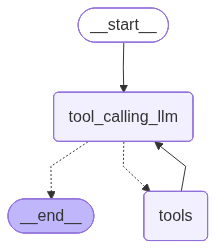

In [32]:
## Entire chatbot with langgraph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## Nodes definition
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build Graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition, "tools")
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [34]:
messages = graph.invoke({"messages":HumanMessage(content="provide the top 10 recent AI news for October 1st 2025")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

provide the top 10 recent AI news for October 1st 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_6TBItppdqd5dnmY8YhhNESeN)
 Call ID: call_6TBItppdqd5dnmY8YhhNESeN
  Args:
    query: AI news October 1 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News for Oct 1, 2025 - The Automated Daily", "url": "https://theautomateddaily.com/e/ai-news-for-oct-1-2025/", "content": "SOL: 2GiJB87sSzt6kEhQ54L7NXQwAik5ACFTp3aRpqh76KBJ  \n  \nToday's topics:  \n-Claude Sonnet 4.5 breakthrough coding\n  \n-Anthropic's Claude Agent SDK\n  \n-AI in cybersecurity defense\n  \n-NVIDIA GPU matmul kernel insights\n  \n-DeepSeek-V3.2-Exp sparse attention\n  \n-Tencent HunyuanImage-3.0 multimodal model\n  \n-LoRA fine-tuning research\n  \n-Glean and Zoom AI integ

In [35]:
messages = graph.invoke({"messages":HumanMessage(content="provide the top 5 recent AI news for October 1st 2025 and then add 5 plus 5 and then multiply with 10")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

provide the top 5 recent AI news for October 1st 2025 and then add 5 plus 5 and then multiply with 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_y46vbrOdmCbevDRcxwVfGijd)
 Call ID: call_y46vbrOdmCbevDRcxwVfGijd
  Args:
    query: AI news October 1 2025
  add (call_uFmUmwV6feM2f6Y2Xqitv7C1)
 Call ID: call_uFmUmwV6feM2f6Y2Xqitv7C1
  Args:
    a: 5
    b: 5
  multiply (call_b4j2Ryom2aRqphPCgWk0nfBS)
 Call ID: call_b4j2Ryom2aRqphPCgWk0nfBS
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News for Oct 1, 2025 - The Automated Daily", "url": "https://theautomateddaily.com/e/ai-news-for-oct-1-2025/", "content": "SOL: 2GiJB87sSzt6kEhQ54L7NXQwAik5ACFTp3aRpqh76KBJ  \n  \nToday's topics:  \n-Claude Sonnet 4.5 breakthrough codi

## Memory

In [36]:
messages = graph.invoke({"messages":HumanMessage(content="can you divide it by 10")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you divide it by 10
================================== Ai Message ==================================

Please provide the number you would like to divide by 10.


## Memory Saver

LangGraph can use the checkpointer to automatically save the graph state after each step

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the state update

One of the easiest checkpointers to use is the MemorySaver, as in-memory key-value store store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has Memory!

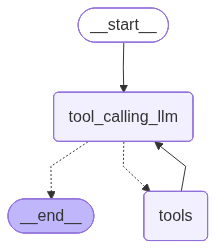

In [37]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)

#view
display(Image(graph_memory.get_graph().draw_mermaid_png()))

# Specify the Thread

In [39]:
config={"configurable":{"thread_id": "1"}}
# specify the input
messages = [HumanMessage(content="Add 12 and 13")]
messages = graph_memory.invoke({"messages":messages}, config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (call_inn8Psqn0HBB1bJ2wVUI2tYA)
 Call ID: call_inn8Psqn0HBB1bJ2wVUI2tYA
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.


In [40]:
messages = [HumanMessage(content="Add that number to 25")]
messages = graph_memory.invoke({"messages":messages}, config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (call_inn8Psqn0HBB1bJ2wVUI2tYA)
 Call ID: call_inn8Psqn0HBB1bJ2wVUI2tYA
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_NPKZ5gzvuZtoAZDn4Nycvzga)
 Call ID: call_NPKZ5gzvuZtoAZDn4Nycvzga
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The sum of 25 and 25

# Streaming


Methods: .stream() & .astream()

-> These methods are sync & async methods for streaming back results

Additional parameters in streaming modes for graph state.

-> values: This streams the full state of the graph after each node is called.

-> updates: This streams updates to the state of the graph after each node is called

In [43]:
config = {"configurable": {"thread_id": "2"}}
# UPDATES
for chunk in graph_memory.stream({'messages': "Hi, My name is Jeevan and I play Basketball"}, config=config,stream_mode="updates"):
    print(chunk)

{'tool_calling_llm': {'messages': [AIMessage(content="Hi Jeevan! It's great to meet you! Basketball is an awesome sport. How long have you been playing, and do you have a favorite team or player?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 458, 'total_tokens': 492, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNOvcyFgY0mEQlQtqWqGMdSGeKphJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ed34da98-a18a-480d-bf1b-e408c0caa501-0', usage_metadata={'input_tokens': 458, 'output_tokens': 34, 'total_tokens': 492, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [44]:
config = {"configurable": {"thread_id": "2"}}
# VALUES
for chunk in graph_memory.stream({'messages': "Hi, My name is Jeevan and I play Basketball"}, config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Jeevan and I play Basketball', additional_kwargs={}, response_metadata={}, id='5eb253b0-c39f-4cd8-983c-932b066132cd'), AIMessage(content="Hi Jeevan! That's great to hear! Basketball is an exciting sport. Do you play for fun, or are you part of a team?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 359, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNOv3LzeOHvWR0phmw8lWCHPagJEe', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8e9ce3bd-62cd-4f8c-84eb-f23b2c251f17-0', usage_metadata={'input_tokens': 359, 'output_tokens': 30, 'total_tokens': 389, 'input_token_details':

In [45]:
config = {"configurable": {"thread_id": "2"}}
# VALUES
for chunk in graph_memory.stream({'messages': "Hi, I also like cooking"}, config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Jeevan and I play Basketball', additional_kwargs={}, response_metadata={}, id='5eb253b0-c39f-4cd8-983c-932b066132cd'), AIMessage(content="Hi Jeevan! That's great to hear! Basketball is an exciting sport. Do you play for fun, or are you part of a team?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 359, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CNOv3LzeOHvWR0phmw8lWCHPagJEe', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8e9ce3bd-62cd-4f8c-84eb-f23b2c251f17-0', usage_metadata={'input_tokens': 359, 'output_tokens': 30, 'total_tokens': 389, 'input_token_details':

# Streaming the Responses with "astream" method

Streaming tokens: we often want to stream more than graph state

In particular, with chat model calls it is common to stream the tokens as they are generated.

we can do this using the astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

-> event: This is the type of event that is being emitted.

-> name: This is the name of the event.

-> data: This is the data associated with the event

-> metadata: contains langgraph_node, the node that is emitting the event

In [47]:
config: {"configurable": {"thread_id": 3}}

async for event in graph_memory.astream_events({"messages":["Hi my name is jeevanand i like to play cricket"]},config,version='v2'):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi my name is jeevanand i like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'e4d03623-b90c-4b6e-91a9-6bfb43cc0cd3', 'metadata': {'thread_id': '2'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, My name is Jeevan and I play Basketball', additional_kwargs={}, response_metadata={}, id='5eb253b0-c39f-4cd8-983c-932b066132cd'), AIMessage(content="Hi Jeevan! That's great to hear! Basketball is an exciting sport. Do you play for fun, or are you part of a team?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 359, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerpri